In [1]:
# Initial imports
import os
import requests
import pandas as pd
#import alpaca_trade_api as tradeapi
#from dotenv import load_dotenv
from pycoingecko import CoinGeckoAPI
%matplotlib inline

cg = CoinGeckoAPI()

# Load .env environment variables
#load_dotenv()

# Set Alpaca API key and secret
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
#alpaca = tradeapi.REST(
#    alpaca_api_key,
#    alpaca_secret_key,
#    api_version="v2")

## Initialize some dictionary and lists
portfolio_dict={}  # portfolio dictionary init
portfolio_list=[]  # list of portfolio tickers init
social_dict={} # dictionary for social data init
equities_dict={} #dictionary for equities data init
equities_list=[]


In [2]:

def get_crypto_portfolio_data(data):
### Uses get_price from the sdk and returns data for the users portfolio
    data = cg.get_price(ids=data,vs_currencies='usd', include_market_cap='true', include_24hr_vol='true', include_24hr_change='true', include_last_updated_at='false')
    return data


def get_coin_by_id(data):
### returns information about the coin including social data
    data = cg.get_coin_by_id(id=data,localization='false',tickers='false',market_data='false')
    return data


def create_crypto_portfolio_df(data):
##returns a portfolio dataframe of the users crypto picks
    
    #the coin name is the first key in the api return data. We need it.
    coin = list(data.keys())[0] 

    #dictionary from the data
    portfolio_dict[coin] = data[coin]

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(portfolio_dict, orient='index')

    #wrangle the data into a portfolio
    df.columns=['Price', 'Market Cap', '24h Volume', '24h Change']
    df['Market Cap'] = df['Market Cap'].astype('int64')
    #df['24h Volume '] = df['24h Volume '].astype('int32')
    df['24h Change'] = df['24h Change'].astype('float64').round(decimals=2)

    #return the dataframe
    return df


def get_social_df(tickers):
# accepts a list of tickers and returns social inco in a dataframe

    for ticker in tickers:
        data=get_coin_by_id(ticker)
        social_dict[data['id']] = data['community_data']

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(social_dict, orient='index')
    df.columns=['FB Likes', 'TWTR Follows', 'reddit posts 48h', 'reddit comments 48h','reddit subscribes 48h','reddit active 48h','telegram users']
        
    #return the dataframe
    return df



def get_equities_df(data):

    # Format current date as ISO format
    today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

    # Set timeframe to one day ('1D') for the Alpaca API
    timeframe = "1D"

    # Get current closing prices for FB and TWTR
    df_portfolio = alpaca.get_barset(
        tickers,
        timeframe,
        start = today,
        end = today
    ).df

    # Display sample data
    df_portfolio



def get_crypto_5yr_history(data=''):
    
    #Get the 5 year history 
    history = cg.get_coin_market_chart_range_by_id(id = 'bitcoin', vs_currency ='usd', from_timestamp='1420070400', to_timestamp= '1604544364')
    
    
    #wrangle the data
    prices = history['prices']
    market_caps = history['market_caps']
    total_volumes = history['total_volumes']
    
    #create the dataframes
    prices_df = pd.DataFrame(prices).set_index(0)
    market_caps_df = pd.DataFrame(market_caps).set_index(0)
    total_volumes_df = pd.DataFrame(total_volumes).set_index(0)
    
    #concat the dataframes
    joined = pd.concat([prices_df,market_caps_df,total_volumes_df], axis = 1, join = 'inner').reset_index()
    joined.columns = ['Date', 'Price', 'Market Caps', 'Total Volumes']
    joined['Date'] = pd.to_datetime(joined['Date'], unit = 'ms')
    
    #return the 5 yr hostry dataframe
    return joined
    
    


In [3]:
while True:
    tickers = input("Please enter a ticker symbol. For equities prefix symbol with % (like %APPL).Make an empty entry when finished: ")

    #Check if a blank was entered. If so, end the dictionary creation.
    if tickers == '':
        break

    if tickers[0] == '%':
        equities_list.append(tickers)
        print("We can get stock data this way some day, but no yet....")
        continue

    try:
        #call the function to get crypto data
        api_data=get_crypto_portfolio_data(tickers)
        
        #Check that we have data. If not, inform users and continue while
        if not api_data:
            print(f"\t\t\t- {str(tickers).upper()} is not a valid symbol, please try again...")
            continue
        else:
            print(f"\t\t\t+ {str(tickers).upper()} has been added to the portfolio.")

      
        #create the portfolio 
        portfolio_df = create_crypto_portfolio_df(api_data)
        
        #append to the list of portfolio tickers for use elsewhere
        portfolio_list.append(tickers)

    except:
        pass

			+ ETHEREUM has been added to the portfolio.
			- DS,KJHGD is not a valid symbol, please try again...
			+ BITCOIN has been added to the portfolio.
			+ CHAINLINK has been added to the portfolio.
			+ LITECOIN has been added to the portfolio.


In [4]:


print(f"\n\nPortfolio")
print(f"{portfolio_df}")
print(f"\n\nTickers for 5 year data pull or other:\nportfolio_list={portfolio_list}")
#print(f"\n\n Social Data {social_df}")





Portfolio
              Price    Market Cap    24h Volume  24h Change
ethereum     460.77   52191965040  1.592775e+10        7.36
bitcoin    15595.35  288685754453  3.049629e+10        0.46
chainlink     12.93    5055408041  1.289846e+09       14.87
litecoin      63.55    4168910358  3.007060e+09        3.95


Tickers for 5 year data pull or other:
portfolio_list=['ethereum', 'bitcoin', 'chainlink', 'litecoin']


<AxesSubplot:>

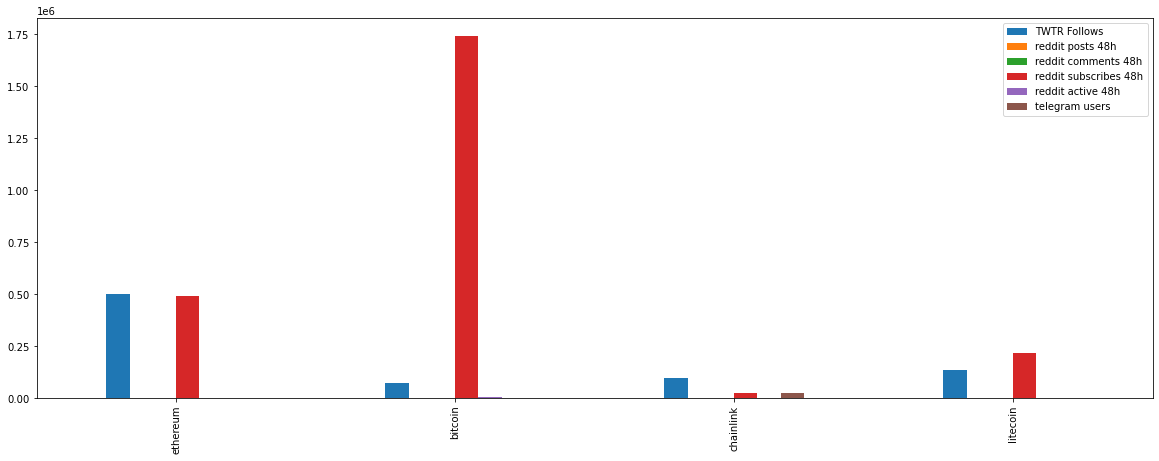

In [5]:
social_df = get_social_df(portfolio_list)
social_df.plot(kind='bar',figsize=(20,7))

In [6]:
history=get_crypto_5yr_history()
history

,Date,Price,Market Caps,Total Volumes
0,2015-01-01,313.992000,4.293958e+09,4.699936e+07
1,2015-01-02,314.446000,4.301448e+09,3.885591e+07
2,2015-01-03,286.572000,3.921358e+09,1.187789e+08
3,2015-01-04,260.936000,3.571640e+09,2.055001e+08
4,2015-01-05,273.220000,3.740880e+09,1.550381e+08
...,...,...,...,...
2129,2020-11-01,13778.637638,2.553293e+11,2.269120e+10
2130,2020-11-02,13720.361465,2.542603e+11,1.977196e+10
2131,2020-11-03,13558.361796,2.512662e+11,2.263085e+10
2132,2020-11-04,13989.976358,2.592772e+11,2.260286e+10
